In [1]:
using CSV, DataFrames, Dates, Distributions, Extremes, Optim, Gadfly, SpecialFunctions

In [2]:
df = CSV.read("pcp.csv", DataFrame)
filter!(row -> year(row.Date)<2024, df)

filter!(row -> month(row.Date) ∈ 5:10, df)

dropmissing!(df)

df.Year = year.(df.Date)

data = combine(groupby(df, :Year), :pcp => maximum => :Maximum)

first(data, 5)

5×2 DataFrame
 Row │ Year   Maximum 
     │ Int64  Float64 
─────┼────────────────
   1 │  1942     45.0
   2 │  1943     54.1
   3 │  1944     25.7
   4 │  1945     37.6
   5 │  1946     52.1

In [3]:
x = data.Maximum;

# Estimation par maximum de vraisemblance

In [4]:
fm = gevfit(data, :Maximum)

MaximumLikelihoodAbstractExtremeValueModel
model :
	BlockMaxima{GeneralizedExtremeValue}
	data :		Vector{Float64}[82]
	location :	μ ~ 1
	logscale :	ϕ ~ 1
	shape :		ξ ~ 1

θ̂  :	[38.02350480754306, 2.407446692153568, 0.005517514300944534]


In [5]:
θ̂ = fm.θ̂
Extremes.loglike(fm)

-327.535122667457

In [5]:
parametervar(fm)

3×3 Matrix{Float64}:
  2.04154     0.0600765   -0.0624392
  0.0600765   0.00923295  -0.00393237
 -0.0624392  -0.00393237   0.0105189

## Vérification de l'ajustement

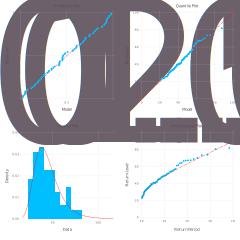

In [6]:
set_default_plot_size(24cm, 24cm)
diagnosticplots(fm)

## Intervalle de confiance sur les paramètres

### Convergence asymptotique des estimateurs du maximum de la vraisemblance

In [7]:
cint(fm)

3-element Vector{Vector{Float64}}:
 [35.223057223716246, 40.82395239136988]
 [2.219117156237006, 2.59577622807013]
 [-0.19549929131979726, 0.2065343199216863]

### Vraisemblance profilée

In [8]:
function fobj(μ::Real, ϕ::Real, ξ::Real)
    
    σ = exp(ϕ)
    
    l = sum(logpdf(GeneralizedExtremeValue(μ, exp(ϕ), ξ), x))
        
    return -l
end

fobj (generic function with 1 method)

In [9]:
function g₃(ξ::Real)
     
    res = optimize(θ -> fobj(θ[1], θ[2], ξ), [location(fm)[], log(Extremes.scale(fm)[])], LBFGS())
    
    return -res.minimum
    
end

g₃ (generic function with 1 method)

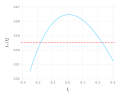

In [10]:
a = Extremes.loglike(fm)-quantile(Chisq(1), .95)/2

set_default_plot_size(12cm, 10cm)

plot(g₃, -.3, .3, 
    yintercept=[a], Geom.hline(color="red", style=:dot),
    Guide.xlabel("ξ"), Guide.ylabel("ℓₚ(ξ)"))

In [11]:
h(ξ::Real) = (g₃(ξ) - a)^2 

lower = optimize(h, -.3, 0.).minimizer
upper = optimize(h, 0, .3).minimizer

[lower, upper]

2-element Vector{Float64}:
 -0.17977529935384334
  0.2263821063389724

## Quantile 1/100

In [12]:
rl = returnlevel(fm, 100)

rl.value

1-element Vector{Float64}:
 89.76463252856362

### Méthode delta

In [13]:
cint(rl)

1-element Vector{Vector{Real}}:
 [68.32468640841219, 111.20457864871506]

### Vraisemblance profilée

In [14]:
function fobj(z::Real, ϕ::Real, ξ::Real)
    
    σ = exp(ϕ)
    
    μ = z + σ/ξ*(1 - (-log(99/100))^(-ξ) )
    
    l = sum(logpdf(GeneralizedExtremeValue(μ, exp(ϕ), ξ), x))
        
    return -l
end

fobj (generic function with 1 method)

In [15]:
function g₃(z::Real)
     
    res = optimize(θ -> fobj(z, θ[1], θ[2]), [log(Extremes.scale(fm)[]), shape(fm)[]])
    
    return -res.minimum
    
end

g₃ (generic function with 1 method)

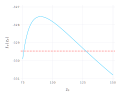

In [16]:
a = Extremes.loglike(fm)-quantile(Chisq(1), .95)/2

set_default_plot_size(12cm, 10cm)

plot(g₃, 75, 150, 
    yintercept=[a], Geom.hline(color="red", style=:dot),
    Guide.xlabel("zₚ"), Guide.ylabel("ℓₚ(zₚ)"))

In [17]:
h(ξ::Real) = (g₃(ξ) - a)^2 

lower = optimize(h, 75., 100.).minimizer
upper = optimize(h, 100., 150.).minimizer

[lower, upper]

2-element Vector{Float64}:
  75.89931031006104
 127.42632382747354

# Estimation par la méthode des moments pondérés

In [18]:
fm = gevfitpwm(data, :Maximum)

pwmAbstractExtremeValueModel
model :
	BlockMaxima{GeneralizedExtremeValue}
	data :		Vector{Float64}[82]
	location :	μ ~ 1
	logscale :	ϕ ~ 1
	shape :		ξ ~ 1

θ̂  :	[38.00875883093535, 2.445629371069762, -0.009183961359865454]


## Vérification de l'ajustement

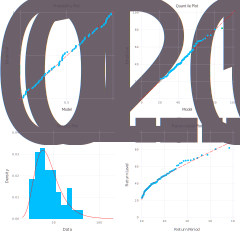

In [19]:
set_default_plot_size(24cm, 24cm)
diagnosticplots(fm)

## Intervalle de confiance sur les paramètres

In [20]:
cint(fm)

3-element Vector{Vector{Float64}}:
 [35.337587810547795, 41.115562928293656]
 [2.233582241101688, 2.621840515649195]
 [-0.14215089802347639, 0.10108224564028519]

## Quantile 1/100

In [21]:
rl = returnlevel(fm, 100)

rl.value

1-element Vector{Float64}:
 89.97886574739152

### Intervalle de confiance

Bootstrap

In [22]:
cint(rl)

1-element Vector{Vector{Real}}:
 [77.5132604974802, 99.6977662679226]

# Le maximum de 2024 ...

En 2024 suite au passage du cyclone extra-tropical Debby, plus de 154 mm. Le précédent record était de 93.5 mm.

## Loi GEV ajustée sur les données 1942 à 2023

In [23]:
fm = gevfit(data, :Maximum)

MaximumLikelihoodAbstractExtremeValueModel
model :
	BlockMaxima{GeneralizedExtremeValue}
	data :		Vector{Float64}[82]
	location :	μ ~ 1
	logscale :	ϕ ~ 1
	shape :		ξ ~ 1

θ̂  :	[38.02350480754306, 2.407446692153568, 0.005517514300944534]


In [24]:
# Calcul de la période de retour de l'événement de 2024

pd = Extremes.getdistribution(fm)[]

T = 1/ccdf(pd, 154)

25676.401460938672

## Loi Gumbel ajustée sur les données 1942 à 2023

In [25]:
fm = gumbelfit(data, :Maximum)

MaximumLikelihoodAbstractExtremeValueModel
model :
	BlockMaxima{Gumbel}
	data :		Vector{Float64}[82]
	location :	μ ~ 1
	logscale :	ϕ ~ 1

θ̂  :	[38.05658624985094, 2.4095520884871826]


In [26]:
# Calcul de la période de retour de l'événement de 2024

pd = Extremes.getdistribution(fm)[]

T = 1/ccdf(pd, 154)

33462.214964836356